## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp #to download the huggingface dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import pickle
from sklearn.preprocessing import LabelEncoder



def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.13.0


Importing the Dataset

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
#loading the .pkl file
file_path = 'merged_training.pkl'

with open(file_path, 'rb') as file:
  dataset = pickle.load(file)


In [4]:
#this corpus sometimes contains spaces in the place of apostrophes, the following function removes
# these spaces
def remove_spaces_before_letters_other_than_i(sentence):
    words = sentence.split()  # Split the sentence into words
    modified_words = [words[0]]  # Initialize the modified words with the first word

    for i in range(1, len(words)):
        if words[i] != 'i' and words != 'a' and words[i].isalpha() and len(words[i]) == 1:
            modified_words[-1] = (words[i-1]+words[i])  # Remove the space and concatenate the word
        else:
            modified_words.append(words[i])  # Keep the word as is

    modified_sentence = ' '.join(modified_words)  # Rejoin the modified words into a sentence

    return modified_sentence
s="i m alone i feel awful"
print(remove_spaces_before_letters_other_than_i(s))

im alone i feel awful


In [5]:
dataset['text'] = dataset['text'].apply(remove_spaces_before_letters_other_than_i)

In [6]:
#splitting the dataset
train = dataset[:14001]
validate = dataset[14001:17001]
test = dataset[17001:20001]

In [7]:
# train

,text,emotions
27383,i feel awful about it too because its my job t...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feelinga little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
90210,i just feel like there should be more useful i...,joy
29335,i feel about we are handsome,joy
117390,i wanted or needed to feel popular i just had ...,joy
18951,i groan feeling the sweet sensation all the wa...,love


In [8]:
# converts the columns of the dataframe to lists
def get_tweet(data):
    tweets = data['text'].tolist()
    labels = data['emotions'].tolist()
    return tweets, labels

In [9]:
tweets, labels = get_tweet(train)

In [10]:
tweets[0], labels[0]

('i feel awful about it too because its my job to get him ina position to succeed and it just didnt happen here',
 'sadness')

Tokenization

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words = 10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

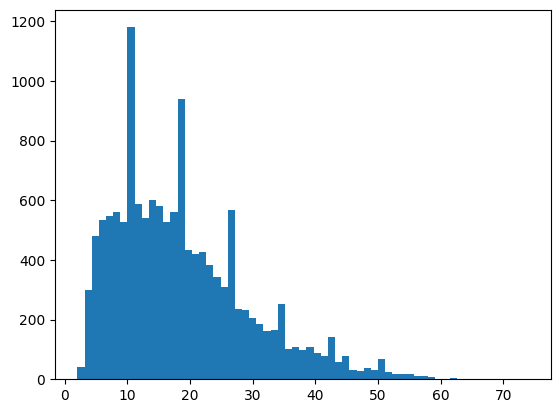

In [13]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [14]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [16]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [17]:
padded_train_seq[7]

array([  2,   3, 319, 513,  26,  23,  30,  23, 112, 875, 194,  49, 386,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [18]:
classes = set(labels)
print(classes)

{'sadness', 'surprise', 'joy', 'love', 'fear', 'anger'}


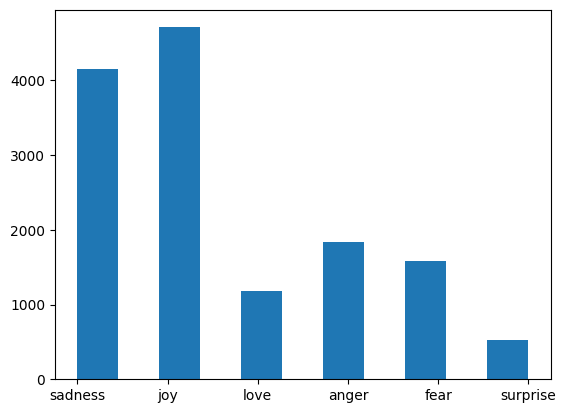

In [19]:
plt.hist(labels, bins=11)
plt.show()

In [20]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((i,c) for c,i in class_to_index.items())

In [21]:
encoded_labels = lambda labels: np.array([class_to_index.get(x) for x in labels])
train_labels = encoded_labels(labels)

Creating the Model

1. Creating the model
2. Compiling the model

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [24]:
# model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training the Model

1. Preparing a validation set
2. Training the model

In [32]:
val_tweets, val_labels = get_tweet(validate)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = encoded_labels(val_labels)

In [36]:
h =  model.fit(
    padded_train_seq, train_labels, validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
438/438 [==============================] - 43s 69ms/step - loss: 1.3622 - accuracy: 0.4638 - val_loss: 0.8630 - val_accuracy: 0.6800
Epoch 2/20
438/438 [==============================] - 11s 24ms/step - loss: 0.6632 - accuracy: 0.7487 - val_loss: 0.6414 - val_accuracy: 0.7487
Epoch 3/20
438/438 [==============================] - 11s 26ms/step - loss: 0.4082 - accuracy: 0.8612 - val_loss: 0.4853 - val_accuracy: 0.8330
Epoch 4/20
438/438 [==============================] - 9s 21ms/step - loss: 0.2521 - accuracy: 0.9189 - val_loss: 0.5058 - val_accuracy: 0.8540
Epoch 5/20
438/438 [==============================] - 8s 19ms/step - loss: 0.1824 - accuracy: 0.9419 - val_loss: 0.4400 - val_accuracy: 0.8607
Epoch 6/20
438/438 [==============================] - 8s 18ms/step - loss: 0.1409 - accuracy: 0.9560 - val_loss: 0.5333 - val_accuracy: 0.8540
Epoch 7/20
438/438 [==============================] - 8s 18ms/step - loss: 0.1268 - accuracy: 0.9594 - val_loss: 0.4462 - val_accuracy: 0.8

Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

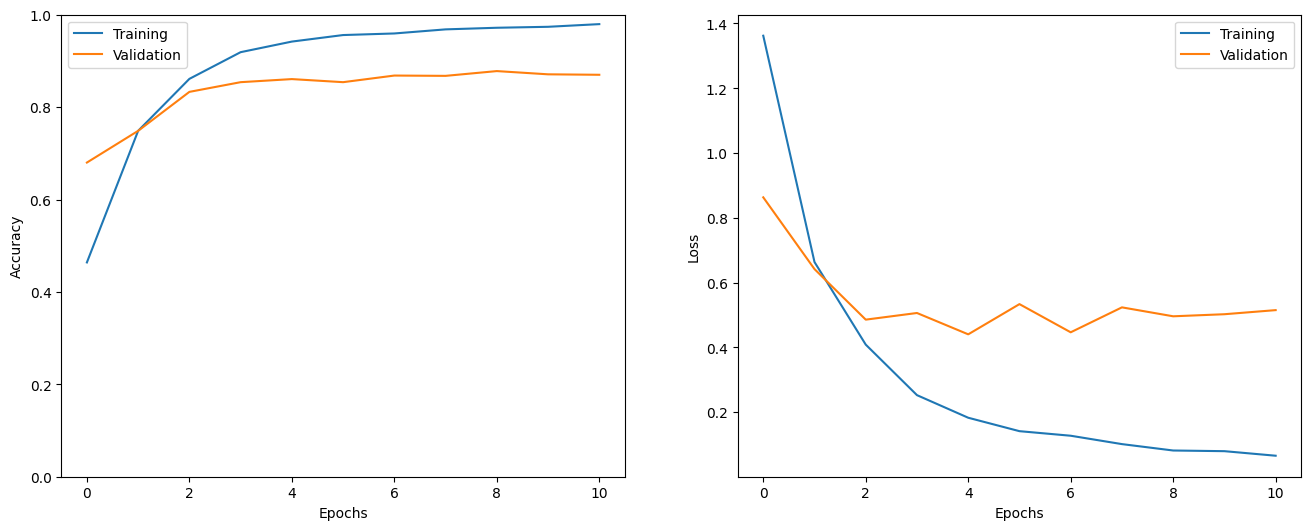

In [37]:
show_history(h)

In [39]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = encoded_labels(test_labels)

In [40]:
_ = model.evaluate(test_seq, test_labels)

94/94 [==============================] - 1s 12ms/step - loss: 0.5369 - accuracy: 0.8670


In [50]:
i =random.randint(0, len(test)-1)
print('Sentence:',test_tweets[i])
print('Emotion:',index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
predicted_emotion = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:',predicted_emotion)

Sentence: im not sure this isa good thing mostly because you feel extremely hot whatever youre wearing
Emotion: love
1/1 [==============================] - 0s 32ms/step
Predicted Emotion: love


In [57]:
predictions = model.predict(test_seq)
predicted_labels = np.argmax(predictions, axis=1)

94/94 [==============================] - 1s 6ms/step


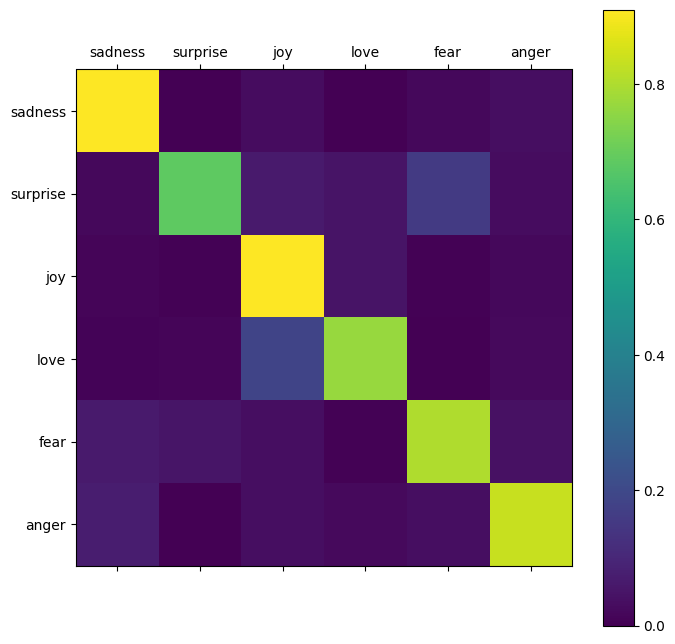

In [58]:
show_confusion_matrix(test_labels, predicted_labels, list(classes))